In [12]:
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
from tabulate import tabulate
from numpy import *

In [15]:
class BS:
    def __init__(self,spot, strike, rate, dte,volatility):
        self.spot = spot
        self.strike = strike
        self.rate = rate
        self.dte = dte
        self.volatility = volatility
        self._a_ = self.volatility* self.dte**0.5 

        if self.strike == 0:
            raise ZeroDivisionError('The strike price cannot be zero')
        else:
            self._d1_ = (log(self.spot / self.strike) +
                         (self.rate + (self.volatility**2) / 2) * self.dte) / self._a_
        self._d2_ = self._d1_ - self._a_

        self._b_ = e**-(self.rate + (self.dte))

        for i in ['callPrice', 'putPrice', 'callDelta', 'putDelta', 'callTheta', 'putTheta',
                  'callRho', 'putRho', 'vega', 'gamma']:
            self.__dict__[i] = None

        [self.callPrice, self.putPrice] = self._price()
        [self.callDelta, self.putDelta] = self._delta()
        [self.callTheta, self.putTheta] = self._theta()
        [self.callRho, self.putRho] = self._rho()
        self.vega = self._vega()
        self.gamma = self._gamma()

    def _price(self):
        if self.volatility == 0 or self.dte == 0:
            call = maximum(0.0,self.spot - self.strike)
            put = maximum(0.0, self.strike - self.spot)
        else:
            call = self.spot * norm.cdf(self._d1_) - self.strike * e**(-self.rate *
                                                                       self.dte) * norm.cdf(self._d2_)
            put = self.strike * e**(-self.rate * self.dte) * norm.cdf(-self._d2_) - \
                self.spot * norm.cdf(-self._d1_)
        return [call, put]

    def _delta(self):
        if self.volatility == 0 or self.dte ==0:
            call = 1.0 if self.spot > self.strike else 0.0
            put = 1.0 if self.spot < self.strike else 0.0
        else:
            call = norm.cdf(self._d1_)
            put = norm.cdf(self._d2_)
        return[call, put]
    
    def _gamma(self):
        return norm.pdf(self._d1_) / (self.spot * self._a_)
    
    def _vega(self):
        if self.volatility == 0 or self.dte == 0:
            return 0.0
        else:
            return self.spot * norm.pdf(self._d1_) * self.dte**0.5 /100
    
    def _theta(self):
        call = -self.spot * norm.pdf(self._d1_) * self.volatility / (
            2 * self.dte**0.5) - self.rate * self.strike * self._b_ * norm.cdf(self._d2_)

        put = -self.spot * norm.pdf(self._d1_) * self.volatility / (
            2 * self.dte**0.5) + self.rate * self.strike * self._b_ * norm.cdf(-self._d2_)
        return [call / 365, put / 365]
    
    def _rho(self):
        call = self.strike * self.dte * self._b_ * norm.cdf(self._d2_) / 100
        put = -self.strike * self.dte * self._b_ * norm.cdf(-self._d2_) / 100

        return [call, put]


In [20]:
option = BS(100,100,0.0,1,0.2)

header = ['Option Price', 'Delta', 'Gamma', 'Theta', 'Vega', 'Rho']
table = [[option.callPrice, option.callDelta, option.gamma,
          option.callTheta, option.vega, option.callRho]]


In [21]:
print(tabulate(table,header))

  Option Price     Delta      Gamma       Theta      Vega       Rho
--------------  --------  ---------  ----------  --------  --------
       7.96557  0.539828  0.0198476  -0.0108754  0.396953  0.169288


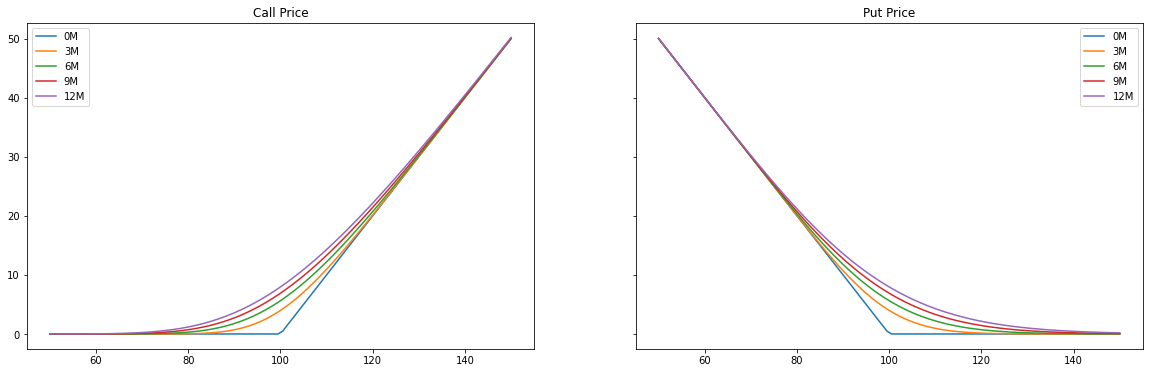

In [23]:
figure, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

x = linspace(50, 150, 100)
d = {'0M': 1e-50, '3M': 0.25, '6M': 0.5, '9M': 0.75, '12M': 1.0}

for k, v in d.items():
    axes[0].plot(x, BS(x, 100, 0.0, v, 0.2).callPrice, label=k)
    axes[1].plot(x, BS(x, 100, 0.0, v, 0.2).putPrice, label=k)

# Set axis title
axes[0].set_title('Call Price'), axes[1].set_title('Put Price')

# Define legend
axes[0].legend(), axes[1].legend()

plt.show()


Text(0.5, 1.0, 'ATM Straddle Price')

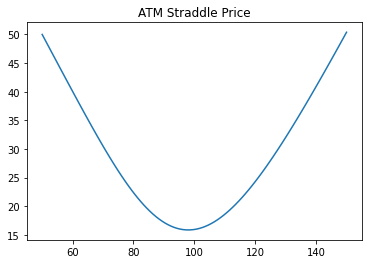

In [24]:
plt.plot(x, (BS(x,100,0.0,1,0.2).callPrice+BS(x,100,0.0,1,0.2).putPrice))
plt.title('ATM Straddle Price')

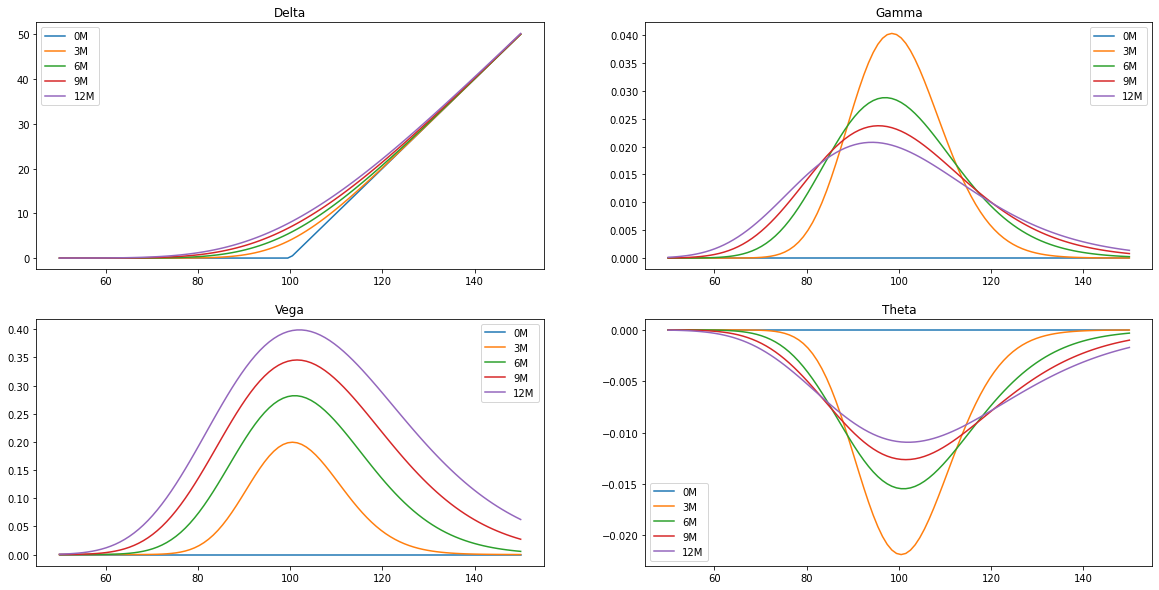

In [25]:
fig, ax = plt.subplots(2,2,figsize =(20,10))
for k,v in d.items():
    ax[0,0].plot(x,BS(x,100,0.0,v,0.2).callPrice, label =k)
    ax[0,1].plot(x, BS(x, 100, 0.0, v, 0.2).gamma, label=k)
    ax[1, 0].plot(x, BS(x, 100, 0.0, v, 0.2).vega, label=k)
    ax[1, 1].plot(x, BS(x, 100, 0.0, v, 0.2).callTheta, label=k)

ax[0, 0].set_title('Delta'), ax[0, 1].set_title(
    'Gamma'), ax[1, 0].set_title('Vega'), ax[1, 1].set_title('Theta')

ax[0, 0].legend(), ax[0, 1].legend(), ax[1, 0].legend(), ax[1, 1].legend()

plt.show()

In [27]:
import yfinance as yf

In [51]:
spy = yf.Ticker('SPY')
options = spy.option_chain('2021-12-06')


In [52]:
spot = 440
strike = 440 
rate = 0.0
dte = 0.16712
vol = 0.2185
spy_opt = 0.2185
spy_opt = BS(spot, strike, rate, dte,vol)

In [53]:
print(f'Option price of SPY210930C0040000 with BS model is {spy_opt.callPrice:0.4f}')

Option price of SPY210930C0040000 with BS model is 15.6742


In [55]:
df = options.calls[options.calls['strike'] > 440]
df.reset_index(drop=True, inplace=True)

# Check the filtered output
df.iloc[:, :11].head()


,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility
0,SPY211206C00445000,2021-11-02 19:52:14,445.0,19.77,0.0,0.0,0.0,0.0,1.0,0,0.00001
1,SPY211206C00448000,2021-11-08 18:21:50,448.0,23.22,0.0,0.0,0.0,0.0,3.0,0,0.00001
2,SPY211206C00450000,2021-11-04 17:31:00,450.0,19.02,0.0,0.0,0.0,0.0,4.0,0,0.00001
3,SPY211206C00451000,2021-11-08 16:26:10,451.0,20.83,0.0,0.0,0.0,0.0,1.0,0,0.00001
4,SPY211206C00452000,2021-11-05 17:16:25,452.0,19.01,0.0,0.0,0.0,0.0,1.0,0,0.00001


In [56]:
df = pd.DataFrame({
    'Strike': df['strike'],
    'Price': df['lastPrice'],
    'ImpVol':df['impliedVolatility']
})

df.head()

,Strike,Price,ImpVol
0,445.0,19.77,0.00001
1,448.0,23.22,0.00001
2,450.0,19.02,0.00001
3,451.0,20.83,0.00001
4,452.0,19.01,0.00001


In [57]:
df['Delta'] = df['Gamma'] = df['Vega'] = df['Theta'] = 0.

for i in range(len(df)):
    df['Delta'].iloc[i] = BS(spot, df['Strike'].iloc[i],
                             rate, dte, df['ImpVol'].iloc[i]).callDelta
    df['Gamma'].iloc[i] = BS(spot, df['Strike'].iloc[i],
                             rate, dte, df['ImpVol'].iloc[i]).gamma
    df['Vega'].iloc[i] = BS(spot, df['Strike'].iloc[i],
                            rate, dte, df['ImpVol'].iloc[i]).vega
    df['Theta'].iloc[i] = BS(spot, df['Strike'].iloc[i],
                             rate, dte, df['ImpVol'].iloc[i]).callTheta


In [58]:
df.head()

,Strike,Price,ImpVol,Delta,Gamma,Vega,Theta
0,445.0,19.77,0.00001,0.0,0.0,0.0,-0.0
1,448.0,23.22,0.00001,0.0,0.0,0.0,-0.0
2,450.0,19.02,0.00001,0.0,0.0,0.0,-0.0
3,451.0,20.83,0.00001,0.0,0.0,0.0,-0.0
4,452.0,19.01,0.00001,0.0,0.0,0.0,-0.0


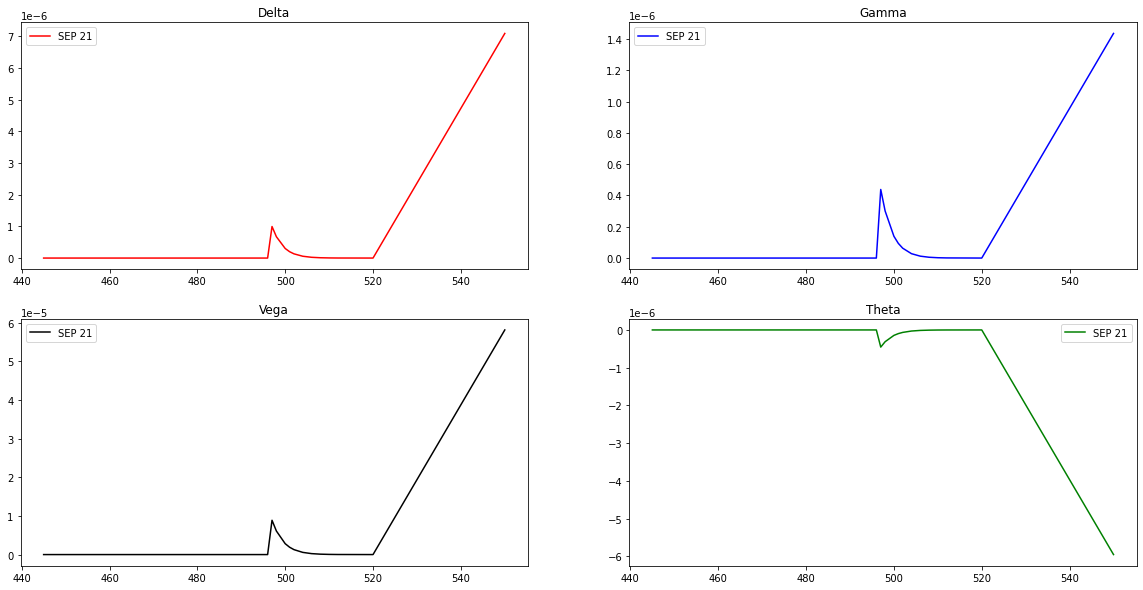

In [59]:
# Visualize the data
# Plot graph iteratively
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

ax[0, 0].plot(df['Strike'], df['Delta'], color='r', label='SEP 21')
ax[0, 1].plot(df['Strike'], df['Gamma'], color='b', label='SEP 21')
ax[1, 0].plot(df['Strike'], df['Vega'], color='k', label='SEP 21')
ax[1, 1].plot(df['Strike'], df['Theta'], color='g', label='SEP 21')

# Set axis title
ax[0, 0].set_title('Delta'), ax[0, 1].set_title(
    'Gamma'), ax[1, 0].set_title('Vega'), ax[1, 1].set_title('Theta')

# Define legend
ax[0, 0].legend(), ax[0, 1].legend(), ax[1, 0].legend(), ax[1, 1].legend()

plt.show()
